In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
import sklearn as sk
import sklearn.discriminant_analysis as da
import sklearn.neighbors as knn
from IPython.display import Markdown, display
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
df = pd.read_csv('listings.csv')

In [3]:
df['price'] = df['price'].replace('[\$,)]','', regex=True).replace('[(]','-', regex=True).astype(float)
df['log_price'] = np.log(df['price'].values)
display(df.head())
df.columns

,id,scrape_id,last_scraped,name,picture_url,host_id,host_name,host_since,host_picture_url,street,...,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,log_price
0,1069266,20150101184336,2015-01-02,Stay like a real New Yorker!,https://a0.muscache.com/pictures/50276484/larg...,5867023,Michael,2013-04-10,https://a2.muscache.com/ic/users/5867023/profi...,"East 53rd Street, New York, NY 10022, United S...",...,2014-12-17,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1,5.075174
1,1846722,20150101184336,2015-01-02,Apartment 20 Minutes Times Square,https://a1.muscache.com/pictures/35865039/larg...,2631556,Denise,2012-06-13,https://a2.muscache.com/ic/users/2631556/profi...,"West 155th Street, New York, NY, United States",...,2014-12-29,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2,4.653960
2,2061725,20150101184336,2015-01-02,Option of 2 Beds w Private Bathroom,https://a2.muscache.com/pictures/50650147/larg...,4601412,Miao,2013-01-05,https://a0.muscache.com/ic/users/4601412/profi...,"Van Buren Street, Brooklyn, NY 11221, United S...",...,2014-12-29,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4,4.060443
3,44974,20150101184336,2015-01-03,Charming Bright West Village Studio,https://a1.muscache.com/pictures/20489905/larg...,198425,Sara,2010-08-11,https://a0.muscache.com/ic/users/198425/profil...,"Greenwich Ave, New York, NY 10011, United States",...,2014-10-30,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1,5.220356
4,4701675,20150101184336,2015-01-02,Charming Apartment in Chelsea,https://a2.muscache.com/pictures/60588955/larg...,22590025,Charles,2014-10-15,https://a2.muscache.com/ic/users/22590025/prof...,"West 22nd Street, New York, NY 10011, United S...",...,2014-12-08,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,5.273000


Index([u'id', u'scrape_id', u'last_scraped', u'name', u'picture_url',
       u'host_id', u'host_name', u'host_since', u'host_picture_url', u'street',
       u'neighbourhood', u'neighbourhood_cleansed', u'city', u'state',
       u'zipcode', u'market', u'country', u'latitude', u'longitude',
       u'is_location_exact', u'property_type', u'room_type', u'accommodates',
       u'bathrooms', u'bedrooms', u'beds', u'bed_type', u'square_feet',
       u'price', u'weekly_price', u'monthly_price', u'guests_included',
       u'extra_people', u'minimum_nights', u'maximum_nights',
       u'calendar_updated', u'availability_30', u'availability_60',
       u'availability_90', u'availability_365', u'calendar_last_scraped',
       u'number_of_reviews', u'first_review', u'last_review',
       u'review_scores_rating', u'review_scores_accuracy',
       u'review_scores_cleanliness', u'review_scores_checkin',
       u'review_scores_communication', u'review_scores_location',
       u'review_scores_value', u'h

Looks like a normal distribution

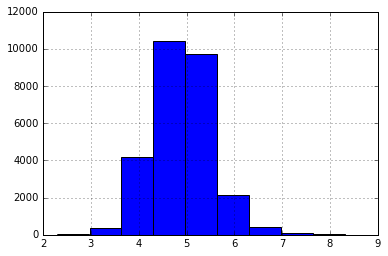

In [4]:
#Lets plot a histogram of the log(price) 
df.log_price.hist()
Markdown('Looks like a normal distribution')

In [5]:
not_interesting_cols = ['id','last_scraped','state','scrape_id','name','picture_url', 'host_id', 'host_name', 'host_since', 'host_picture_url', 'street',
       'neighbourhood', 'country', 'price', 'weekly_price', 'monthly_price',
        'calendar_updated', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'calendar_last_scraped', 'last_review', 'first_review']

data = df.drop(not_interesting_cols, axis=1)

## Missing Values 

In [6]:
#Replace blanks with NaNs
data = data.replace('_', np.nan)

col_analysis = []
for column in data.columns:
    numNulls = len(data[column][data[column].isnull()])
    totalLength = len(data[column])
    dict1 = {'Name':column,'DataType':data[column].dtype, 'NumberOfNulls':numNulls, 'PercentageNulls':numNulls*100.0/totalLength}
    col_analysis.append(dict1)
    
col_anal_df = pd.DataFrame(col_analysis)[['Name', 'DataType','NumberOfNulls','PercentageNulls']].sort_values(by='PercentageNulls', ascending=False)

useful_cols = col_anal_df[col_anal_df.PercentageNulls < 50.0]

print 'List of Predictors and their respective percentages of missing values'
display(useful_cols.head(10))

for cols in data.columns.values:
    if (np.any(useful_cols.Name.values == cols) == False):
        data.drop(cols, axis=1, inplace=True)
        
data.head(5)

List of Predictors and their respective percentages of missing values


,Name,DataType,NumberOfNulls,PercentageNulls
26,review_scores_value,float64,8734,31.885222
25,review_scores_location,float64,8732,31.877921
22,review_scores_cleanliness,float64,8731,31.874270
24,review_scores_communication,float64,8731,31.874270
23,review_scores_checkin,float64,8729,31.866968
21,review_scores_accuracy,float64,8727,31.859667
20,review_scores_rating,float64,8657,31.604118
10,bathrooms,float64,463,1.690275
2,zipcode,object,162,0.591414
11,bedrooms,float64,140,0.511098


,neighbourhood_cleansed,city,zipcode,market,latitude,longitude,is_location_exact,property_type,room_type,accommodates,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,log_price
0,Midtown East,New York,10022,New York,40.756852,-73.964754,t,Apartment,Entire home/apt,2,...,62,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1,5.075174
1,Hamilton Heights,New York,NaN,New York,40.830599,-73.941014,f,Apartment,Entire home/apt,10,...,22,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2,4.653960
2,Bushwick,Brooklyn,11221,New York,40.692189,-73.924120,t,Apartment,Private room,2,...,35,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4,4.060443
3,West Village,New York,10011,New York,40.734751,-74.002592,t,Apartment,Entire home/apt,2,...,26,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1,5.220356
4,Chelsea,New York,10011,New York,40.745282,-73.997836,t,Apartment,Entire home/apt,2,...,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,5.273000


## Impute Missing Values

In [7]:
#Use Mean for Real values Columns
real_value_cols = useful_cols[useful_cols.DataType == 'float64']
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
data[real_value_cols.Name.values] = imp.fit_transform(data[real_value_cols.Name.values])


#Use Highest frequency for categorical columns
categorical_value_cols = useful_cols[useful_cols.DataType == 'object'].Name.values
data[categorical_value_cols] = data[categorical_value_cols].apply(lambda x:x.fillna(x.value_counts().index[0]))

data.head()


,neighbourhood_cleansed,city,zipcode,market,latitude,longitude,is_location_exact,property_type,room_type,accommodates,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,log_price
0,Midtown East,New York,10022,New York,40.756852,-73.964754,t,Apartment,Entire home/apt,2,...,62,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1,5.075174
1,Hamilton Heights,New York,11211,New York,40.830599,-73.941014,f,Apartment,Entire home/apt,10,...,22,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2,4.653960
2,Bushwick,Brooklyn,11221,New York,40.692189,-73.924120,t,Apartment,Private room,2,...,35,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4,4.060443
3,West Village,New York,10011,New York,40.734751,-74.002592,t,Apartment,Entire home/apt,2,...,26,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1,5.220356
4,Chelsea,New York,10011,New York,40.745282,-73.997836,t,Apartment,Entire home/apt,2,...,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,5.273000


## Convert Categorical Variables to dummy integer values here
- We convert the categorical variables to numeric here such that we can run models that work only with numbers

## One-Hot Encoding


In [8]:
data_ohe = data.copy(deep= True)

#Encode categorical variables
def encode_categorical(array):
    return preprocessing.LabelEncoder().fit_transform(array) 


categorical_value_cols = useful_cols[useful_cols.DataType == 'object'].Name.values


#Convert Categories to numbers here
data_ohe[categorical_value_cols] = data_ohe[categorical_value_cols].apply(encode_categorical)

# Apply one hot endcoing
# Leads to inferior performance and hence we disable for now
#data_ohe = pd.get_dummies(data_ohe.ix[:,:-1], columns=categorical_value_cols)

print 'Final Dataset ready for modelling after filling in missing values, and encoding categorical variables'
data_ohe.head()

Final Dataset ready for modelling after filling in missing values, and encoding categorical variables


,neighbourhood_cleansed,city,zipcode,market,latitude,longitude,is_location_exact,property_type,room_type,accommodates,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,log_price
0,112,104,21,0,40.756852,-73.964754,1,0,0,2,...,62,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1,5.075174
1,80,104,106,0,40.830599,-73.941014,0,0,0,10,...,22,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2,4.653960
2,20,32,116,0,40.692189,-73.924120,1,0,1,2,...,35,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4,4.060443
3,176,104,12,0,40.734751,-74.002592,1,0,0,2,...,26,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1,5.220356
4,25,104,12,0,40.745282,-73.997836,1,0,0,2,...,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,5.273000


## Separate response from predictors

In [9]:
x = data_ohe.values[:, :-1]
y = data_ohe.values[:, -1]

#response = df_filtered[['log_price']]
#predictors =  df_filtered.drop(['log_price'], axis=1)

## Split into train/test

In [10]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

## Simple Regression Model

In [11]:
#OLS regression
clf = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
clf.fit(x_train, y_train)
predicted = clf.predict(x_test)

score = sk.metrics.r2_score(y_test, predicted)
print('sklearn: R2 score for Linear Regression is: {}'.format(score))

sklearn: R2 score for Linear Regression is: 0.614574354441
